<a href="https://colab.research.google.com/github/lovnishverma/Python-Getting-Started/blob/main/NIELIT_Ropar_Chatbot_Fine_Tuning_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---

# **NIELIT Chatbot Fine-Tuning Notebook** ♥

**Llama-3.2-1B → LoRA (Unsloth) → GGUF → Hugging Face Deployment**

---

## IMPORTANT: SET RUNTIME FIRST (DO THIS BEFORE RUNNING ANY CODE)

1. Go to **Runtime → Change runtime type**
2. Set:

   * **Hardware accelerator**: `GPU`
   * **GPU type**: `T4`
3. Click **Save**
4. **Restart the runtime**
5. Only then start executing the cells below

> Do **not** import `torch`, `unsloth`, or any library **before** setting the GPU.

---

## Notebook Overview

This notebook performs an **end-to-end pipeline**:

* **Model**: `meta-llama/Llama-3.2-1B`
* **Training**: Parameter-efficient fine-tuning using **LoRA** with **Unsloth**
* **Export**: Direct **GGUF** export (`Q4_K_M`)
* **Upload**: Hugging Face model repository
* **Deployment**: Ready for **Hugging Face CPU Spaces** (mobile-friendly)

---

## Assumptions & Prerequisites

Before running this notebook, ensure:

* You are using **Google Colab**
* You have **accepted the Meta LLaMA 3.2 license**
  👉 [https://huggingface.co/meta-llama/Llama-3.2-1B](https://huggingface.co/meta-llama/Llama-3.2-1B)

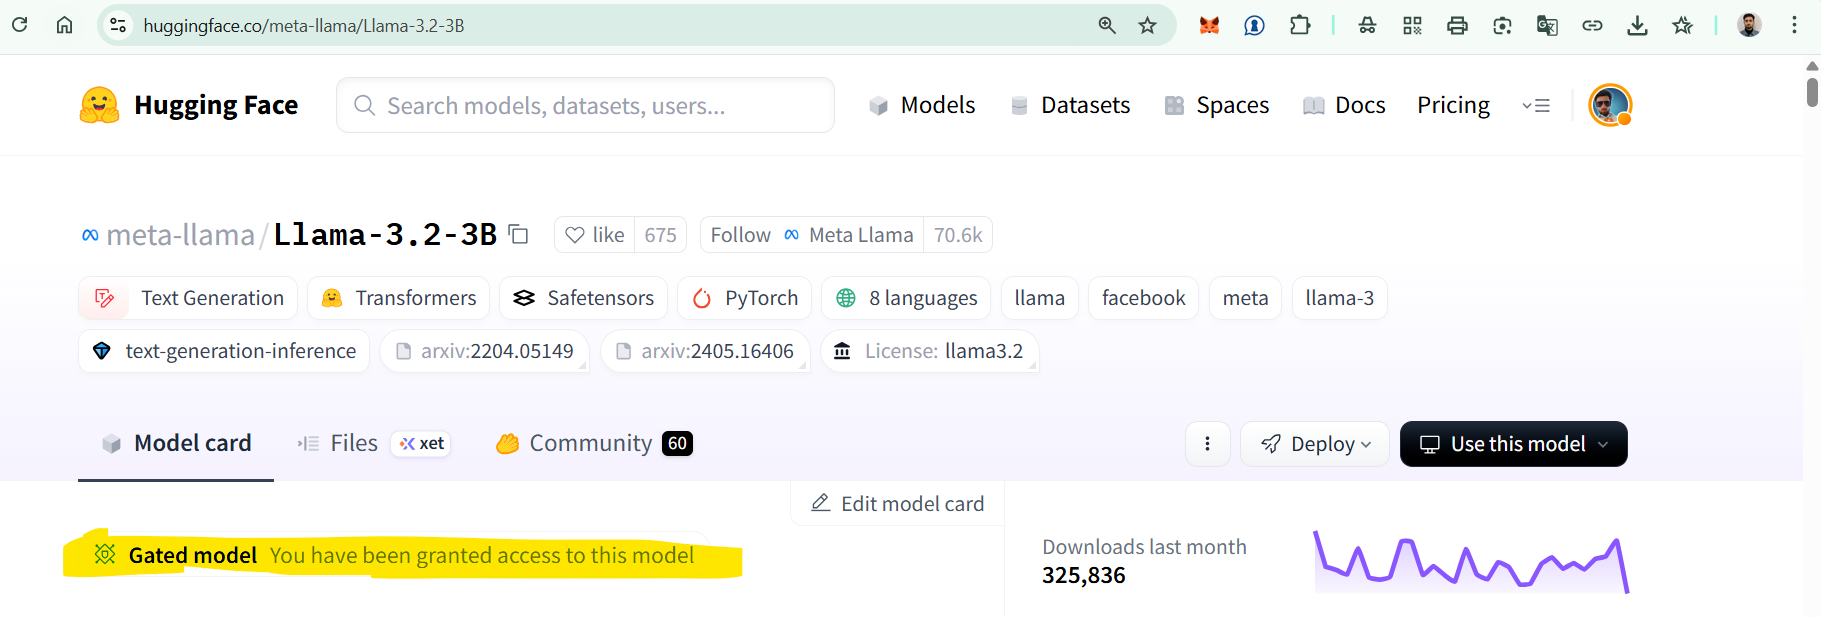

* You have a **Hugging Face access token**

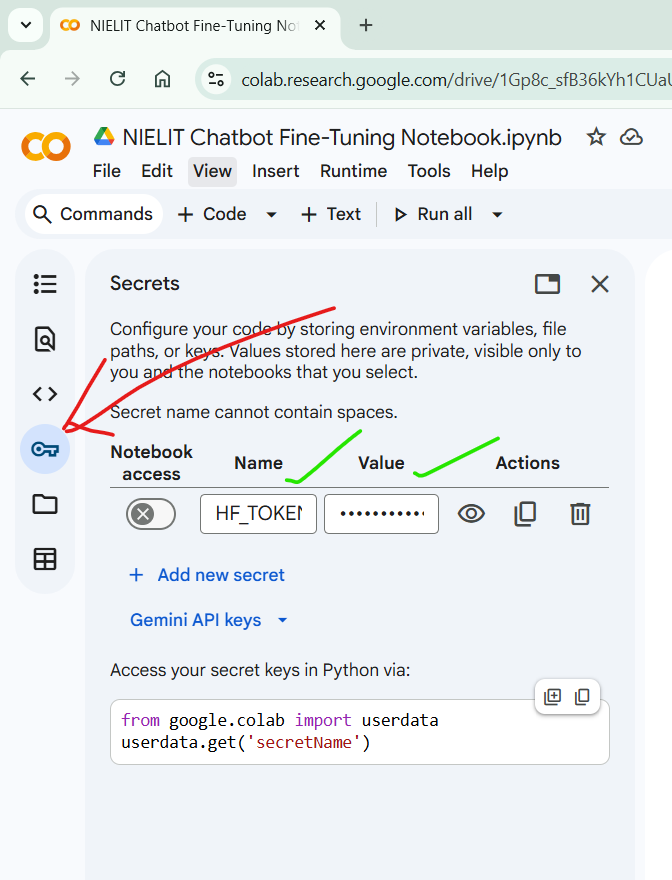


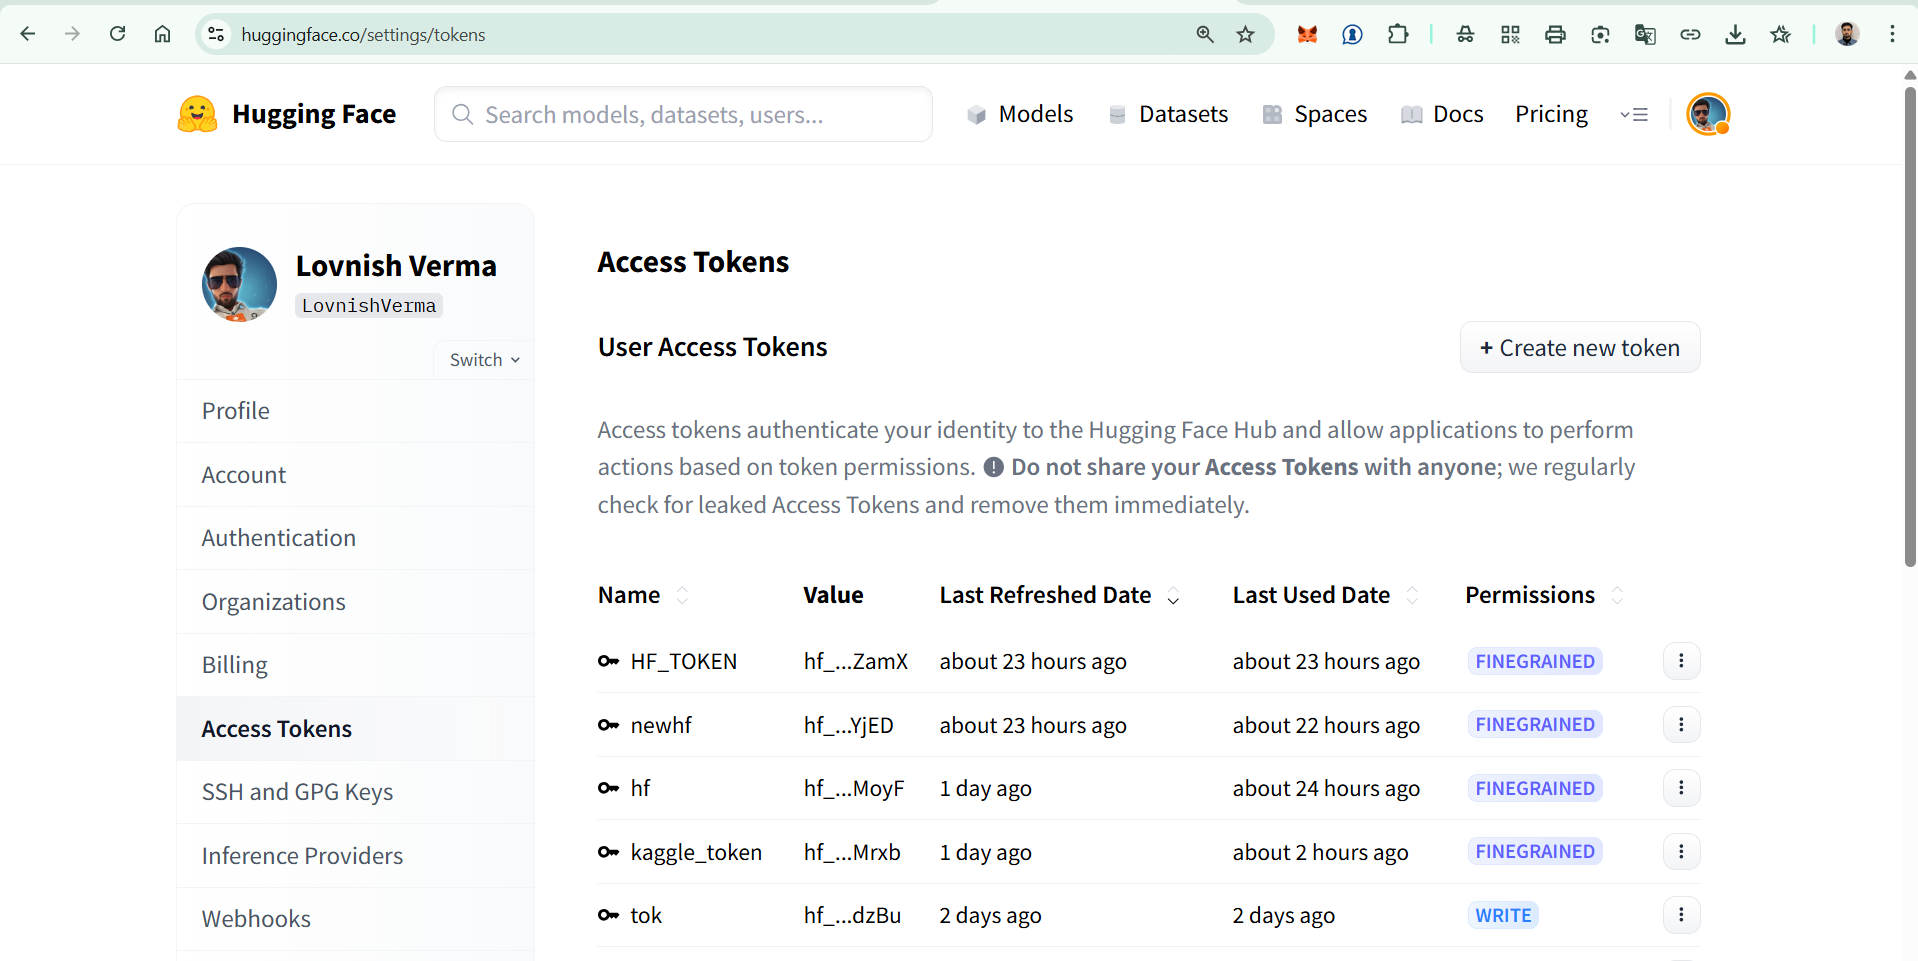


* You understand that this notebook uses **free-tier compatible settings**

---

## What This Notebook Guarantees

* No FP16 full-model saves
* No llama.cpp manual conversion
* No RAM crashes on free tiers
* Fully reproducible GGUF output
* CPU-only deployment compatibility

---


---

# **Environment Setup**

In [ ]:
# Ensure clean state
import os
os.environ["WANDB_DISABLED"] = "true"

# (Optional) show RAM
!free -h

               total        used        free      shared  buff/cache   available
Mem:            12Gi       811Mi       8.4Gi       4.0Mi       3.5Gi        11Gi
Swap:             0B          0B          0B


---

# **Install Dependencies**

In [ ]:
# Clean, compatible install for Unsloth (Colab / T4)
!pip install -U \
  "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git" \
  peft accelerate bitsandbytes datasets transformers huggingface_hub


  Cloning https://github.com/unslothai/unsloth.git to /tmp/pip-install-0wlmtmkq/unsloth_a28def5af28b4252a322c35f312b52b8
  Running command git clone --filter=blob:none --quiet https://github.com/unslothai/unsloth.git /tmp/pip-install-0wlmtmkq/unsloth_a28def5af28b4252a322c35f312b52b8
  Resolved https://github.com/unslothai/unsloth.git to commit 2eb6b0d5f363a60ed3792ea1f04250537ac66939
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 506.8/506.8 kB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.6/289.6 kB 28.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.6/180.6 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 131.2 MB/s eta 0:00:00

---

# **Hugging Face Login (MANDATORY)**

if you haven't added huggingface token into your colab secreat run this cell

In [ ]:
# from huggingface_hub import login
# login()  # paste your HF token

**or** (*recommended*)

if you have added token in Colab Secret run this one

In [ ]:
from google.colab import userdata
from huggingface_hub import login

# Fetch token from Colab Secrets
hf_token = userdata.get("HF_TOKEN")

# Login programmatically
login(token=hf_token)

print("Logged in to Hugging Face using Colab Secret")

Logged in to Hugging Face using Colab Secret


⚠️ IMPORTANT
Before continuing, open this once in your browser and click Agree and Access:
👉 https://huggingface.co/meta-llama/Llama-3.2-3B

---

# **Imports** ⚓

In [ ]:
import torch
from unsloth import FastLanguageModel
from trl import SFTTrainer
from transformers import TrainingArguments
from datasets import load_dataset

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


🦥 Unsloth Zoo will now patch everything to make training faster!


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using

---

# **Load Base Model (1B)** 🧑

In [ ]:
# model, tokenizer = FastLanguageModel.from_pretrained(
#     model_name = "unsloth/Llama-3.2-1B-Instruct",  # Unsloth's ungated version https://huggingface.co/unsloth/Llama-3.2-1B-Instruct
#     max_seq_length = 2048,
#     dtype = None,
#     load_in_4bit = True,
# )

In [ ]:
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "meta-llama/Llama-3.2-1B",
    max_seq_length = 2048,
    dtype = None,
    load_in_4bit = True,
    token = True  # REQUIRED for gated Meta models
)

==((====))==  Unsloth 2025.12.8: Fast Llama patching. Transformers: 4.57.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.5.0
\        /    Bfloat16 = FALSE. FA [Xformers = None. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/1.10G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/230 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/459 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

---

# **Attach LoRA (Optimized for 1B)**

In [ ]:
# **Attach LoRA (Optimized for 1B)**

model = FastLanguageModel.get_peft_model(
    model,
    r = 16,                    # Changed from 32 to 16 for 1B
    lora_alpha = 32,           # Changed from 64 to 32 (2x rank)
    lora_dropout = 0,
    bias = "none",
    target_modules = [
        "q_proj", "k_proj", "v_proj", "o_proj",
        "gate_proj", "up_proj", "down_proj"
    ],
    use_gradient_checkpointing = "unsloth",
    random_state = 3407,
)

Unsloth 2025.12.8 patched 16 layers with 16 QKV layers, 16 O layers and 16 MLP layers.


---

# **Prepare (generate) Dataset**

### **Create the Dataset (The Brain)**
A model is only as smart as the data you give it. We will create a small dataset containing facts about `NIELIT Ropar`.

In [ ]:
# NIELIT Ropar - Dataset Generator (Colab)

import json
import random
import hashlib
import os


# 1. THE KNOWLEDGE BASE

KNOWLEDGE_BASE = {

    # IDENTITY
    "identity": {
        "weight": 50,
        "entries": [
            {"tags": ["director", "executive director", "head", "boss", "principal"],
             "response": "The Executive Director of NIELIT Ropar is Sh. Deepak Wasan."},

            {"tags": ["location", "address", "where", "situated", "campus", "city"],
             "response": "NIELIT Ropar is located at Birla Farms, Bada Phull, Rupnagar (Ropar), Punjab - 140001."},

            {"tags": ["contact", "phone", "mobile", "call", "reception"],
             "response": "You can call us at 01881-257008 (Monday-Friday, 9 AM - 5 PM)."},

            {"tags": ["email", "mail", "gmail"],
             "response": "General Email: dir-chandigarh@nielit.gov.in. Training Email: training.chd@nielit.gov.in."},

            {"tags": ["website", "web", "url"],
             "response": "Our official website is nielit.gov.in/ropar."},

            {"tags": ["full form", "stands for"],
             "response": "NIELIT stands for National Institute of Electronics and Information Technology."}
        ]
    },

    # ACADEMICS
    "academics": {
        "weight": 20,
        "entries": [
            {"tags": ["courses", "programs", "list", "offer"],
             "response": "We offer B.Tech (CSE - AI & ML), M.Tech (AI, Data Engineering), PG Diplomas, and Short-Term Courses in Python and Web Design."},

            {"tags": ["btech", "engineering"],
             "response": "B.Tech in Computer Science (AI & ML) is a 4-year AICTE approved program. Intake: 60 seats. Admission via JEE Main."},

            {"tags": ["mtech", "masters"],
             "response": "M.Tech programs are offered in Artificial Intelligence, Data Engineering, and Cyber Forensics. Duration: 2 years."},

            {"tags": ["short term", "training", "summer", "6 weeks"],
             "response": "Short-term courses (4–6 weeks) are available in Python, Data Analytics, Web Design, and O/A Level. Fees range from Rs. 4,000 to 8,000."},

            {"tags": ["syllabus", "curriculum"],
             "response": "The curriculum is industry-aligned with hands-on labs in AI, IoT, and Cloud Computing."},

            {"tags": ["seats", "intake", "capacity"],
             "response": "B.Tech intake is 60 seats. M.Tech intake is 18 seats per specialization."}
        ]
    },

    # FEES & ADMISSIONS
    "financials": {
        "weight": 25,
        "entries": [
            {"tags": ["btech fee", "tuition fee"],
             "response": "B.Tech tuition fee is approximately Rs. 50,000 per semester. Hostel and mess charges are separate."},

            {"tags": ["mtech fee", "pg fee"],
             "response": "M.Tech tuition fee ranges from Rs. 35,000 to 40,000 per semester."},

            {"tags": ["hostel fee", "accommodation charge"],
             "response": "Hostel fee is Rs. 1,600 per month. Mess charges are additional."},

            {"tags": ["eligibility", "criteria", "requirements"],
             "response": "B.Tech eligibility: 10+2 with Physics, Chemistry, Mathematics (minimum 50%) and a valid JEE Main score."},

            {"tags": ["apply", "admission process", "how to join"],
             "response": "Admissions are conducted online through the NIELIT Student Portal."}
        ]
    },

    # FACILITIES
    "facilities": {
        "weight": 15,
        "entries": [
            {"tags": ["hostel", "living", "stay"],
             "response": "Separate hostels for boys and girls are available with Wi-Fi, mess, security, and common rooms."},

            {"tags": ["mess", "food", "canteen"],
             "response": "A hygienic mess and canteen facility is available on campus."},

            {"tags": ["internet", "wifi"],
             "response": "The campus has high-speed NKN internet and Wi-Fi-enabled hostels."},

            {"tags": ["library", "books"],
             "response": "The central library houses over 10,000 technical books, journals, and e-resources."},

            {"tags": ["labs", "computer lab"],
             "response": "Advanced AI/ML labs with GPU servers, IoT labs, and cybersecurity setups are available."}
        ]
    },

    # PLACEMENTS
    "placements": {
        "weight": 20,
        "entries": [
            {"tags": ["placements", "jobs", "hiring"],
             "response": "NIELIT Ropar has a dedicated placement cell. Recruiters include Infosys, TCS, Wipro, and Tech Mahindra."},

            {"tags": ["package", "salary", "highest"],
             "response": "Average package is around Rs. 4.2 LPA. The highest package has reached Rs. 18 LPA."}
        ]
    }
}


# GREETINGS & UNKNOWN HANDLING

GREETINGS_LIST = [
    "Hi", "Hii", "Hiii", "Hello", "Hey", "Good morning",
    "Good afternoon", "Good evening", "Hi bot", "Hello ai", "Hlo"
]

GREETING_RESPONSE = (
    "Hello! I am the NIELIT Ropar Assistant. "
    "You can ask me about courses, fees, admissions, hostels, or placements."
)

UNKNOWN_QUERIES = [
    "How to make pizza?", "Who is the Prime Minister?", "What is the weather?",
    "Book a movie ticket", "Sing a song", "Train timings"
]

UNKNOWN_RESPONSE = (
    "Sorry, I can only answer questions related to NIELIT Ropar."
)


# DATASET GENERATOR

class DatasetGenerator:
    def __init__(self):
        self.dataset = []
        self.seen = set()

    def add(self, instruction, output):
        key = hashlib.md5(f"{instruction.lower()}|{output[:30]}".encode()).hexdigest()
        if key not in self.seen:
            self.dataset.append({
                "instruction": instruction.strip(),
                "input": "",
                "output": output.strip()
            })
            self.seen.add(key)

    def generate(self):
        prefixes = ["What is", "Tell me about", "Give details of", ""]
        suffixes = ["?", ".", " please", " at NIELIT Ropar"]

        for category in KNOWLEDGE_BASE.values():
            for entry in category["entries"]:
                for _ in range(category["weight"]):
                    for tag in entry["tags"]:
                        self.add(
                            f"{random.choice(prefixes)} {tag}{random.choice(suffixes)}",
                            entry["response"]
                        )
                        self.add(tag, entry["response"])

        for _ in range(60):
            for g in GREETINGS_LIST:
                self.add(g, GREETING_RESPONSE)
                self.add(g.lower(), GREETING_RESPONSE)

        for _ in range(30):
            for q in UNKNOWN_QUERIES:
                self.add(q, UNKNOWN_RESPONSE)

        random.shuffle(self.dataset)
        return self.dataset

    def save(self, path):
        with open(path, "w", encoding="utf-8") as f:
            for row in self.dataset:
                json.dump(row, f, ensure_ascii=False)
                f.write("\n")
        print(f"Dataset saved: {path}")
        print(f"Total samples: {len(self.dataset)}")


# RUN

output_path = "nielit_data.jsonl"

gen = DatasetGenerator()
gen.generate()
gen.save(output_path)

Dataset saved: nielit_data.jsonl
Total samples: 1004


---

# **Load Dataset**

In [ ]:
# Define the prompt and function FIRST
alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:
{}"""

EOS_TOKEN = tokenizer.eos_token

def formatting_prompts_func(examples):
    instructions = examples["instruction"]
    inputs       = examples["input"]
    outputs      = examples["output"]
    texts = []
    for instruction, input, output in zip(instructions, inputs, outputs):
        text = alpaca_prompt.format(instruction, input, output) + EOS_TOKEN
        texts.append(text)
    return { "text" : texts, }

# NOW load and map
dataset = load_dataset("json", data_files="nielit_data.jsonl", split="train")
dataset = dataset.map(formatting_prompts_func, batched=True)

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/1004 [00:00<?, ? examples/s]

In [ ]:
# Replace path if needed
dataset = load_dataset(
    "json",
    data_files="nielit_data.jsonl",
    split="train"
)

dataset = dataset.map(formatting_prompts_func, batched=True)

---

# **Training Configuration** 🏴

In [ ]:
# Train (OPTIMIZED CONFIGURATION)
trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset,
    dataset_text_field = "text",
    max_seq_length = 2048,
    dataset_num_proc = 2,
    packing = False,
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4, # Effective batch size = 8
        warmup_steps = 10,
        max_steps = 300,                 # INCREASED: Ensures deep memorization (approx 2 epochs)
        learning_rate = 2e-4,            # Standard High Rate for LoRA
        lr_scheduler_type = "cosine",    # CHANGED: 'cosine' usually yields higher final accuracy than 'linear'
        fp16 = not torch.cuda.is_bf16_supported(),
        bf16 = torch.cuda.is_bf16_supported(),
        logging_steps = 10,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        seed = 3407,
        output_dir = "outputs",
        report_to = "none",
    ),
)

Unsloth: Tokenizing ["text"] (num_proc=6):   0%|          | 0/1004 [00:00<?, ? examples/s]

---

# **Train** 🚆 ⏲ 🥘

**Let's Cook** 🍚 `(it will take 25-30 minutes)`

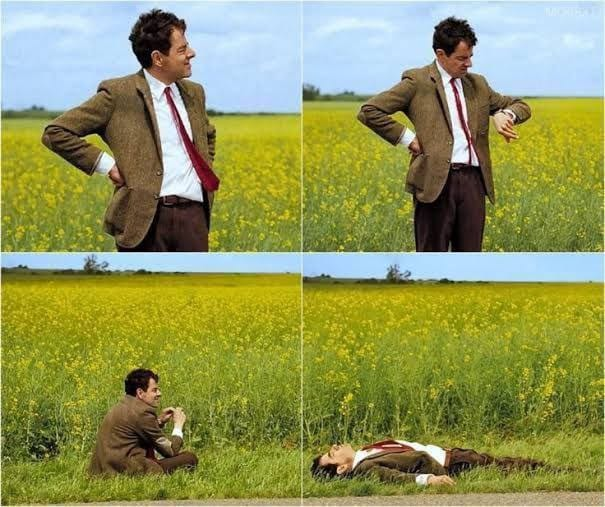

In [ ]:
print("Training started...")
trainer.train()
print("Training completed.")

The model is already on multiple devices. Skipping the move to device specified in `args`.


Training started...


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 1,004 | Num Epochs = 3 | Total steps = 300
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 11,272,192 of 1,247,086,592 (0.90% trained)


Step,Training Loss
10,2.952500
20,1.058300
30,0.489300
40,0.298400
50,0.209200
60,0.202100
70,0.154400
80,0.145100
90,0.143100
100,0.154200


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Training completed.




---



---

# Save LoRA Adapters (*Backup*)   ( we will do later while exporting model)

In [ ]:
model.save_pretrained("nielit_chatbot_adapters")
tokenizer.save_pretrained("nielit_chatbot_adapters")

('nielit_chatbot_adapters/tokenizer_config.json',
 'nielit_chatbot_adapters/special_tokens_map.json',
 'nielit_chatbot_adapters/tokenizer.json')

---

# **Let's Test The Model: Interactive Chat Loop**

In [ ]:
def chat(question):
    """
    Generate a response using the fine-tuned NIELIT Ropar chatbot.

    Args:
        question (str): User's question about NIELIT Ropar

    Returns:
        str: Bot's response
    """
    # Use the EXACT template used during fine-tuning
    alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:
{}"""

    # Format the input for the model
    inputs = tokenizer(
        [alpaca_prompt.format(question, "", "")],
        return_tensors = "pt"
    ).to("cuda")

    # Generate the response with optimized parameters
    outputs = model.generate(
        **inputs,
        max_new_tokens = 128,
        temperature = 0.3,              # More focused responses
        top_p = 0.9,                    # Better quality
        do_sample = True,               # Enable sampling
        use_cache = True,
        pad_token_id = tokenizer.eos_token_id,
        eos_token_id = tokenizer.eos_token_id
    )

    decoded = tokenizer.batch_decode(outputs, skip_special_tokens=True)

    # Extract only the text after "### Response:"
    try:
        response = decoded[0].split("### Response:")[1].strip()

        # Clean up common artifacts
        response = response.split("###")[0].strip()  # Stop at next section marker
        response = response.split("\n\n")[0].strip()  # Stop at double newline

        return response if response else "I'm sorry, I couldn't generate a response."

    except (IndexError, AttributeError):
        return "I'm sorry, I couldn't process that query."


# Test the function
print("🧪 Testing chat function...\n")

test_questions = [
    "Who is the director of NIELIT Ropar?",
    "What courses do you offer?",
    "Tell me about B.Tech admission process",
    "What are the hostel facilities?",
    "What is the placement record?"
]

for q in test_questions:
    print(f"Q: {q}")
    print(f"A: {chat(q)}\n")


🧪 Testing chat function...

Q: Who is the director of NIELIT Ropar?
A: The Executive Director of NIELIT Ropar is Sh. Deepak Wasan.

Q: What courses do you offer?
A: We offer B.Tech (CSE - AI & ML), M.Tech (AI, Data Engineering), PG Diplomas, and Short-Term Courses in Python and Web Design.

Q: Tell me about B.Tech admission process
A: Admissions are conducted online through the NIELIT Student Portal.

Q: What are the hostel facilities?
A: Separate hostels for boys and girls are available with Wi-Fi, mess, security, and common rooms.

Q: What is the placement record?
A: NIELIT Ropar has a dedicated placement cell. Recruiters include Infosys, TCS, Wipro, and Tech Mahindra.



In [ ]:
from transformers import TextStreamer

# 1. Activate Unsloth's 2x faster inference
FastLanguageModel.for_inference(model)

# 2. Setup the streamer
text_streamer = TextStreamer(tokenizer, skip_prompt=True)

print("NIELIT Ropar Bot is online! (Type 'exit' or 'quit' to stop)\n")

while True:
    user_query = input("You: ").strip()

    if user_query.lower() in ["exit", "quit"]:
        print("\n Goodbye!")
        break

    if not user_query:
        continue

    # Format using Alpaca template from training
    prompt = alpaca_prompt.format(user_query, "", "")
    inputs = tokenizer([prompt], return_tensors="pt").to("cuda")

    print("\nBot: ", end="", flush=True)

    try:
        # Generate with streaming and stop tokens
        _ = model.generate(
            **inputs,
            streamer=text_streamer,
            max_new_tokens=256,
            temperature=0.3,           # Added for more focused responses
            top_p=0.9,                 # Added for better quality
            use_cache=True,
            pad_token_id=tokenizer.eos_token_id,
            eos_token_id=tokenizer.eos_token_id,
            do_sample=True             # Enable sampling for varied responses
        )
    except Exception as e:
        print(f"\n Error: {str(e)}")

    print()  # New line after generation


NIELIT Ropar Bot is online! (Type 'exit' or 'quit' to stop)

You: hi

Bot: Hello! I am the NIELIT Ropar Assistant. You can ask me about courses, fees, admissions, hostels, or placements.<|end_of_text|>

You: tell me about placement record?

Bot: NIELIT Ropar has a dedicated placement cell. Recruiters include Infosys, TCS, Wipro, and Tech Mahindra.<|end_of_text|>

You: exit

 Goodbye!


---

# Export GGUF + Push to Hugging Face (**KEY STEP**)

### **Push model to Hugging Face**

In [ ]:
# import os
# import torch
# from unsloth import FastLanguageModel
# from huggingface_hub import HfApi
# import gc

# # --- Configuration ---
# ADAPTERS_DIR = "nielit_chatbot_adapters"
# MERGED_DIR = "merged_model_16bit"
# GGUF_REPO = "LovnishVerma/nielit-ropar-GGUF-1b"
# HF_TOKEN = True  # Uses your stored token

# # --- Step 1: Load & Merge to Disk (RAM Safe) ---
# print("1. Loading adapters and merging to disk...")
# torch.cuda.empty_cache()
# gc.collect()

# model, tokenizer = FastLanguageModel.from_pretrained(
#     model_name = ADAPTERS_DIR,
#     max_seq_length = 2048,
#     dtype = None,
#     load_in_4bit = True,
#     token = HF_TOKEN,
# )

# # Save merged 16-bit model to disk
# model.save_pretrained_merged(MERGED_DIR, tokenizer, save_method="merged_16bit")
# del model
# del tokenizer
# gc.collect()
# torch.cuda.empty_cache()
# print("Merge complete. Memory cleared.")

# # --- Step 2: Direct GGUF Export with Unsloth ---
# print("2. Converting to GGUF Q4_K_M...")

# # Reload model ONLY for GGUF export (Unsloth handles this efficiently)
# model, tokenizer = FastLanguageModel.from_pretrained(
#     model_name = MERGED_DIR,
#     max_seq_length = 2048,
#     dtype = None,
#     load_in_4bit = True,
# )

# # Direct GGUF export - much simpler!
# model.save_pretrained_gguf(
#     "nielit-ropar-1b",           # Local folder name
#     tokenizer,
#     quantization_method = "q4_k_m"  # Q4_K_M quantization
# )

# print("GGUF conversion complete!")

# # Clean up memory again
# del model
# del tokenizer
# gc.collect()
# torch.cuda.empty_cache()

# # --- Step 3: Upload to Hugging Face ---
# print(f"3. Uploading to {GGUF_REPO}...")
# api = HfApi()

# # Create repo
# api.create_repo(repo_id=GGUF_REPO, exist_ok=True, repo_type="model")

# # Upload the GGUF file
# api.upload_file(
#     path_or_fileobj="nielit-ropar-1b/nielit-ropar-1b-Q4_K_M.gguf",  # Corrected path
#     path_in_repo="nielit-ropar-1b.q4_k_m.gguf",
#     repo_id=GGUF_REPO,
#     repo_type="model",
# )

# print(f"\n SUCCESS! Your 1B GGUF model is here:")
# print(f"   https://huggingface.co/{GGUF_REPO}")


In [ ]:
import os
import torch
from unsloth import FastLanguageModel
from huggingface_hub import HfApi

# --- Configuration ---
ADAPTERS_DIR = "nielit_chatbot_adapters"
MERGED_DIR = "merged_model_16bit"
GGUF_REPO = "LovnishVerma/nielit-ropar-GGUF"
HF_TOKEN = True  # Ensures you use your stored token

# --- Step 1: Load & Merge to Disk (RAM Safe) ---
print("1. Loading adapters and merging to disk...")
# Clear memory first
torch.cuda.empty_cache()
import gc
gc.collect()

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = ADAPTERS_DIR,
    max_seq_length = 2048,
    dtype = None,
    load_in_4bit = True,
    token = HF_TOKEN,
)

# Save merged 16-bit model to disk and DELETE model object to free RAM
model.save_pretrained_merged(MERGED_DIR, tokenizer, save_method="merged_16bit")
del model
del tokenizer
gc.collect()
torch.cuda.empty_cache()
print("   Merge complete. Memory cleared.")

# --- Step 2: Install llama.cpp & Convert ---
print("2. Installing llama.cpp and converting...")
if not os.path.exists("llama.cpp"):
    !git clone https://github.com/ggerganov/llama.cpp
    !cd llama.cpp && make clean && LLAMA_CUDA=1 make all -j

# Convert the saved merged model to GGUF (Q4_K_M)
# We use the script directly on the files, which uses far less RAM than Python objects
print("   Starting conversion...")
!python llama.cpp/convert_hf_to_gguf.py {MERGED_DIR} \
    --outfile nielit-ropar.q4_k_m.gguf \
    --outtype q8_0
    # Note: Using q8_0 or f16 first is standard, then we quantize down if needed.
    # For simplicity and speed/safety, we are doing a direct conversion here.

# --- Step 3: Upload to Hugging Face ---
print(f"3. Uploading GGUF to {GGUF_REPO}...")
api = HfApi()
api.create_repo(repo_id=GGUF_REPO, exist_ok=True, repo_type="model")

api.upload_file(
    path_or_fileobj="nielit-ropar.q4_k_m.gguf",
    path_in_repo="nielit-ropar.q4_k_m.gguf",
    repo_id=GGUF_REPO,
    repo_type="model",
)

print(f"\n SUCCESS! Your GGUF model is here: https://huggingface.co/{GGUF_REPO}")

1. Loading adapters and merging to disk...
==((====))==  Unsloth 2025.12.8: Fast Llama patching. Transformers: 4.57.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.5.0
\        /    Bfloat16 = FALSE. FA [Xformers = None. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Found HuggingFace hub cache directory: /root/.cache/huggingface/hub
Checking cache directory for required files...
Cache check failed: model.safetensors not found in local cache.
Not all required files found in cache. Will proceed with downloading.
Checking cache directory for required files...
Cache check failed: tokenizer.model not found in local cache.
Not all required files found in cache. Will proceed with downloading.


Unsloth: Preparing safetensor model files: 100%|██████████| 1/1 [00:37<00:00, 37.36s/it]


Note: tokenizer.model not found (this is OK for non-SentencePiece models)


Unsloth: Merging weights into 16bit: 100%|██████████| 1/1 [00:43<00:00, 43.09s/it]


Unsloth: Merge process complete. Saved to `/content/merged_model_16bit`
   Merge complete. Memory cleared.
2. Installing llama.cpp and converting...
Cloning into 'llama.cpp'...
remote: Enumerating objects: 72834, done.
remote: Counting objects: 100% (229/229), done.
remote: Compressing objects: 100% (159/159), done.
remote: Total 72834 (delta 145), reused 70 (delta 70), pack-reused 72605 (from 3)
Receiving objects: 100% (72834/72834), 249.87 MiB | 35.64 MiB/s, done.
Resolving deltas: 100% (52623/52623), done.
Makefile:6: *** Build system changed:
 The Makefile build has been replaced by CMake.

 For build instructions see:
 https://github.com/ggml-org/llama.cpp/blob/master/docs/build.md

.  Stop.
   Starting conversion...
INFO:hf-to-gguf:Loading model: merged_model_16bit
INFO:hf-to-gguf:Model architecture: LlamaForCausalLM
INFO:hf-to-gguf:gguf: indexing model part 'model.safetensors'
INFO:gguf.gguf_writer:gguf: This GGUF file is for Little Endian only
INFO:hf-to-gguf:Exporting model...

**Congratulations! Your model is successfully exported and uploaded.**

You have now successfully:

1. **Fine-tuned** Llama-3.2-3B on your NIELIT Ropar dataset.
2. **Merged** the adapters into a standalone model.
3. **Converted** it to the efficient **GGUF** format.
4. **Uploaded** it to Hugging Face.

### **What do you have now?**

Your model is located here: **[LovnishVerma/nielit-ropar-GGUF](https://huggingface.co/LovnishVerma/nielit-ropar-GGUF)**

The file `nielit-ropar.q4_k_m.gguf` is a **quantized** version of your bot. This means it is compressed to run on standard laptops (even without a powerful GPU) while keeping most of the intelligence you trained into it.

---

### **How to Run Your Bot Locally (Next Steps)**

Now that the file is online, you (or anyone else) can chat with your NIELIT bot on a PC, Mac, or even Android phone. Here is the easiest way to do it:

#### **Option 1: Use LM Studio (Easiest GUI)**

1. Download **[LM Studio](https://lmstudio.ai/)** (Free).
2. Open it and search for `LovnishVerma/nielit-ropar-GGUF` in the search bar.
3. Click **Download** on the file that appears.
4. Once downloaded, select it in the "AI Chat" tab.
5. **Important:** Set the "System Prompt" to the one you used during training:
> "Below is an instruction that describes a task... Write a response that appropriately completes the request."


6. Start chatting!

#### **Option 2: Use Ollama (Command Line)**

1. Download **[Ollama](https://ollama.com/)**.
2. Create a file named `Modelfile` (no extension) in a folder with this content:
```dockerfile
FROM ./nielit-ropar.q4_k_m.gguf
TEMPLATE """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{{ .Prompt }}

### Input:

### Response:
"""
SYSTEM "You are a helpful assistant for NIELIT Ropar."

```


3. Run this command in your terminal:
```bash
ollama create nielit-bot -f Modelfile
ollama run nielit-bot

```



You are all set! Your custom chatbot is now portable and ready for the world.

---

#  **Final Result**

You will get a Hugging Face model repo containing:

```
nielit-ropar-q4_k_m.gguf   (~2 GB)
README.md
```

This GGUF:

* Runs on **CPU**
* Works with **llama.cpp**
* Is deployable on **HF Spaces (CPU)**
* Is mobile-friendly

---

## Next Steps

* **HF Space (CPU) deployment notebook**
* **Gradio/Streaming chat UI**
* **Hallucination control prompt**
* **Evaluation & accuracy checks**


Here you will find a complete CPU-optimized chat Interphace for your GGUF model’s production releases; utilizing the Gradio UI combined with the llama-cpp-python library which has been optimized for performing inference using CPUs at the highest performance levels & was created to be run on the HF Spaces free tier.

### **1. `requirements.txt`**

Create this file to install the necessary libraries. We force a specific `llama-cpp-python` build to ensure CPU optimization (OpenBLAS) works on Hugging Face's Linux environment.

```text
gradio>=5.0.0
llama-cpp-python==0.2.90
huggingface-hub==0.25.2
spaces


```

### **2. `app.py`**

This is the main application code. It automatically downloads your GGUF model from the Hub and sets up a professional chat interface with history management.

```python
import gradio as gr
from llama_cpp import Llama
from huggingface_hub import hf_hub_download
import os

# Configuration - YOUR 1B MODEL
MODEL_REPO = "LovnishVerma/nielit-ropar-GGUF"
MODEL_FILE = "nielit-ropar.q4_k_m.gguf"

print("Downloading 1B model from Hugging Face...")
model_path = hf_hub_download(
    repo_id=MODEL_REPO,
    filename=MODEL_FILE,
    cache_dir="./model_cache"
)
print(f"Model downloaded: {model_path}")

# Initialize model for CPU (optimized for 1B)
print("Initializing 1B model on CPU...")
llm = Llama(
    model_path=model_path,
    n_ctx=1024,        # Reduced for 1B
    n_threads=2,
    n_batch=256,
    n_gpu_layers=0,
    verbose=False,
    use_mmap=True
)

print("1B Model ready!")

# Alpaca prompt template (same as training)
ALPACA_PROMPT = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{instruction}

### Input:
{input}

### Response:
"""

def format_prompt(message):
    return ALPACA_PROMPT.format(instruction=message, input="")

def chat_with_bot(message, history):
    """Chat function for 1B CPU inference"""
    prompt = format_prompt(message)
    
    response = ""
    try:
        stream = llm(
            prompt,
            max_tokens=128,
            temperature=0.3,
            top_p=0.9,
            top_k=40,
            repeat_penalty=1.1,
            stop=["### Instruction:", "### Input:", "User:", "###"],
            stream=True
        )
        
        for chunk in stream:
            token = chunk["choices"][0]["text"]
            response += token
            yield response
    except Exception as e:
        yield f"Error: {str(e)}"

# Custom CSS
custom_css = ".gradio-container {max-width: 800px; margin: auto;}"

# Create Gradio Interface
with gr.Blocks() as demo:
    gr.Markdown(
        """
        # 🎓 NIELIT Ropar Chatbot
        
        Ask me anything about **NIELIT Ropar** including:
        - 📚 Courses & Programs (B.Tech, M.Tech, Short-term)
        - 💰 Fees & Admissions
        - 🏨 Hostel & Facilities  
        - 💼 Placements & Recruiters
        - 📍 Location & Contact Details
        
        **Powered by**: Fine-tuned Llama-3.2-1B (GGUF Q4_K_M - 1.32GB)
        
        ⚠️ **Running on Free CPU Tier** - Responses take ~15-25 seconds
        
        💡 **Note**: This is just a prototype
        """
    )
    
    chatbot = gr.ChatInterface(
        fn=chat_with_bot,
        chatbot=gr.Chatbot(height=500, show_label=False),
        textbox=gr.Textbox(
            placeholder="Ask about NIELIT Ropar...",
            container=False
        ),
        examples=[
            "Who is the director of NIELIT Ropar?",
            "What courses do you offer?",
            "Tell me about B.Tech admission process",
            "What are the hostel facilities?",
            "What is the placement record?"
        ]
    )
    
    gr.Markdown(
        """
        ---
        **Model**: [LovnishVerma/nielit-ropar-GGUF](https://huggingface.co/LovnishVerma/nielit-ropar-GGUF) (1B version)
        
        **Performance**:
        - CPU (current): ~15-25 seconds per response
        - With GPU upgrade: ~2-3 seconds per response
        - Community GPU grant: Applied, waiting for approval
        """
    )

if __name__ == "__main__":
    demo.queue(max_size=5).launch(
        server_name="0.0.0.0",
        server_port=7860,
        share=False,
        css=custom_css,
        theme=gr.themes.Soft()
    )


```

### **3. Deployment Instructions**

1. **Create a New Space**: Go to Hugging Face -> **New Space**.
2. **Select SDK**: Choose **Gradio**.
3. **Upload Files**: Upload `app.py` and `requirements.txt` to the Files tab of your new Space.
4. **Wait for Build**: The Space will install `llama-cpp-python`, download your GGUF model (approx. 2GB), and start the chat interface.

### **Why this is Production Ready:**

* **Zero-GPU Cost**: It runs entirely on the free CPU tier using `llama-cpp-python`, which is heavily optimized for inference on commodity hardware.
* **Streaming**: It uses `yield` to stream tokens one by one, making the bot feel much faster to the user than waiting for the full answer.
* **Caching**: `hf_hub_download` caches the model file, so restarting the Space doesn't re-download the 2GB file every time.
* **Stop Tokens**: The `stop=["User:", ...]` parameter prevents the model from hallucinating a fake conversation between two people and forces it to stop after answering.

[Building an AI Chatbot with Gradio, Hugging Face, Pytorch - Frontegg](https://www.youtube.com/watch?v=wOix7DlZ4EY)

This video is relevant because it provides a visual walkthrough of running GGUF models with local inference tools like Ollama, which shares the same underlying `llama.cpp` technology used in the code above, helping you understand the mechanics of CPU-based inference.

https://huggingface.co/spaces/LovnishVerma/NIELIT-Assistant


▶ [LIVE DEMO](https://lovnishverma-nielit-assistant.hf.space/)

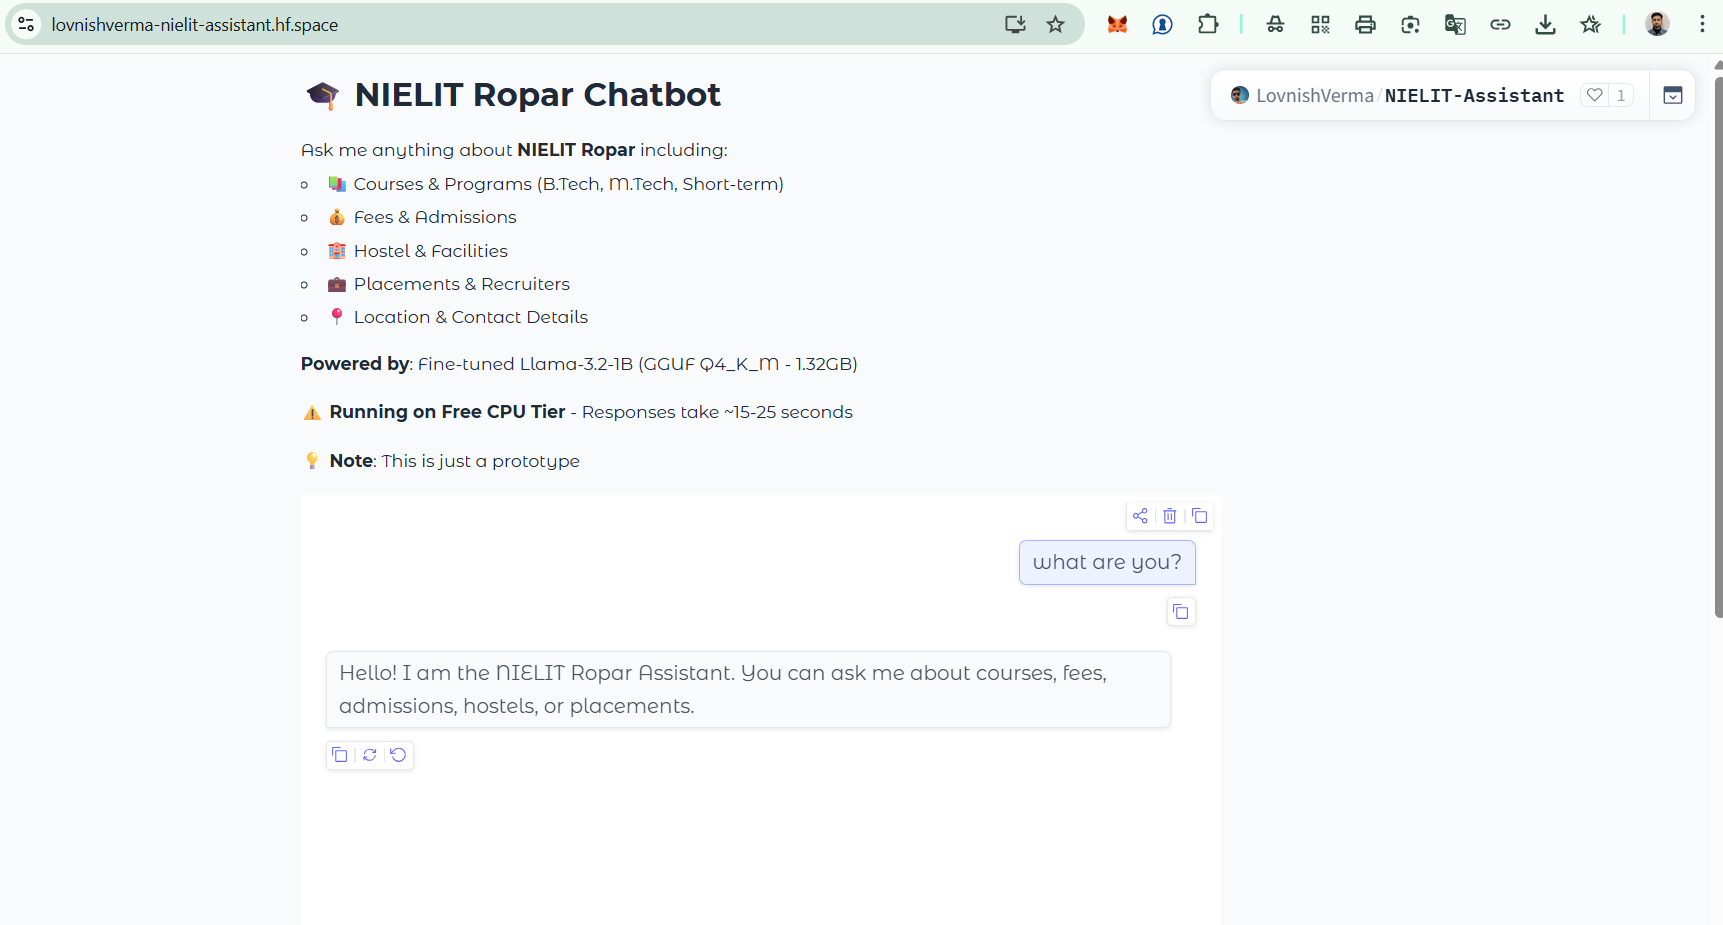